In [ ]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from src.utils import load_cleaned_data, split, compute_metrics, load_config
from transformers import (
    XLMRobertaTokenizer, 
    XLMRobertaForSequenceClassification,
    XLMRobertaConfig,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
    EarlyStoppingCallback
    )
import numpy as np
import torch
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

from datasets import Dataset as HFDataset

In [ ]:
config = load_config("../cfg/xlm_roberta.json")
# Load data from your existing code
data = load_cleaned_data(config["data"]["preprocessed_data_path"])
X = data["full_text"]
y = data["label"]

print(f"Total samples: {len(data)}")
print(f"Label distribution: {y.value_counts().to_dict()}")

print("\nSample article (non-hyperpartisan):")
print(X[y == 0].iloc[0][:200] + "...")
print("\nSample article (hyperpartisan):")
print(X[y == 1].iloc[0][:200] + "...")

Total samples: 645
Label distribution: {0: 407, 1: 238}

Sample article (non-hyperpartisan):
It's 1968 All Over Again. Almost a half-century ago, in 1968, the United States seemed to be falling apart. The Vietnam War, a bitter and close presidential election, antiwar protests, racial riots, p...

Sample article (hyperpartisan):
Kucinich: Reclaiming the money power. Money ( Image by 401(K) 2013 ) Permission Details DMCA No Pill Can Stop Tinnitus, But This 1 Weird Trick Can The walls are closing in on Congress. Terrifying wall...


In [ ]:
# Set up model name and tokenizer from config
model_name = config["model"]["base_model"]
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)

# Set up XLM-RoBERTa configuration from config
xlm_roberta_config = XLMRobertaConfig.from_pretrained(model_name)
xlm_roberta_config.classifier_dropout = config["model"]["classifier_dropout"]
xlm_roberta_config.num_labels = config["model"]["num_labels"]


def tokenize_texts(texts, labels, tokenizer):
    """Tokenize texts and prepare for model input"""
    dataset_dict = {"text": texts.tolist(), "label": labels.tolist()}
    dataset = HFDataset.from_dict(dataset_dict)
    
    def tokenize_function(examples):
        return tokenizer(
            examples["text"],
            padding=config["tokenizer"]["padding"],
            truncation=config["tokenizer"]["truncation"],
            max_length=config["data"]["max_length"],
            return_tensors=config["tokenizer"]["return_tensors"]
        )
    
    # Map tokenization function
    tokenized_dataset = dataset.map(
        tokenize_function, 
        batched=config["tokenizer"]["batch_process"], 
        remove_columns=config["tokenizer"]["remove_columns"]
    )
    
    # Format for PyTorch
    tokenized_dataset.set_format(
        type=config["tokenizer"]["format_type"], 
        columns=config["tokenizer"]["format_columns"]
    )
    
    return tokenized_dataset

In [ ]:
# Set up device
device = None
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    print("No GPU available, using CPU.")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
X_train, X_test, y_train, y_test = split(X, y)
# Cross-validation setup from config
n_splits = config["cross_validation"]["n_splits"]
kf = KFold(
    n_splits=n_splits, 
    shuffle=config["cross_validation"]["shuffle"], 
    random_state=config["cross_validation"]["random_state"]
)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)): # Important: Use X_train for cross-validation, not X
    print(f"\n=== Fold {fold+1}/{n_splits} ===")
    
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
    
    # Apply class balancing if configured
    if config["class_balancing"]["use_balancing"]:
        if config["class_balancing"]["method"] == "oversampling":
            ros = RandomOverSampler(random_state=config["cross_validation"]["random_state"])
            train_indices = np.array(range(len(X_train_fold))).reshape(-1, 1)
            train_indices_resampled, y_train_resampled = ros.fit_resample(train_indices, y_train_fold.values)
            train_indices_resampled = train_indices_resampled.flatten()
            X_train_resampled = X_train_fold.iloc[train_indices_resampled].reset_index(drop=True)
            y_train_resampled = pd.Series(y_train_resampled)
            
            print(f"Original training data distribution: {y_train_fold.value_counts().to_dict()}")
            print(f"Resampled training data distribution: {y_train_resampled.value_counts().to_dict()}")
    else:
        # No resampling
        X_train_resampled, y_train_resampled = X_train_fold, y_train_fold
    
    # Tokenize datasets
    train_dataset = tokenize_texts(
        X_train_resampled, 
        y_train_resampled, 
        tokenizer, 
        max_length=config["data"]["max_length"]
    )
    val_dataset = tokenize_texts(
        X_val_fold, 
        y_val_fold, 
        tokenizer, 
        max_length=config["data"]["max_length"]
    )
    
    # Create a fresh model for this fold
    model = XLMRobertaForSequenceClassification.from_pretrained(
        model_name,
        config=xlm_roberta_config
    ).to(device)
    
    # Create data collator
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    
    # Training arguments from config
    training_args = TrainingArguments(
        output_dir=f"{config["training"]["output_dir"]}/xlm_roberta_fold_{fold+1}",
        learning_rate=config["training"]["learning_rate"],
        per_device_train_batch_size=config["training"]["batch_size"],
        per_device_eval_batch_size=config["training"]["eval_batch_size"],
        num_train_epochs=config["training"]["epochs"],
        weight_decay=config["training"]["weight_decay"],
        evaluation_strategy=config["training"]["evaluation_strategy"],
        save_strategy=config["training"]["save_strategy"],
        load_best_model_at_end=config["training"]["load_best_model_at_end"],
        metric_for_best_model=config["training"]["metric_for_best_model"],
        save_total_limit=config["training"]["save_total_limit"],
        fp16=torch.cuda.is_available(),
    )
    
    # Initialize trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
        callbacks=[
            EarlyStoppingCallback(early_stopping_patience=config["training"]["early_stopping_patience"])
            ]
    )
    
    trainer.train()
    results = trainer.evaluate()
    fold_results.append(results)
    
    # Save model
    trainer.save_model(f"{training_args.output_dir}")
    
    # Clear memory
    del model, trainer
    torch.cuda.empty_cache()


=== Fold 1/5 ===


Map:   0%|          | 0/412 [00:00<?, ? examples/s]

Map:   0%|          | 0/104 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tinnitussen/DAT550/DAT550-2025---Hyperpartisan-News-Detection-/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2345/3456350481.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Precision,Recall,F1
1,No log,0.614007,0.500000,0.000000,0.000000,0.000000
2,No log,0.483341,0.685019,0.714286,0.454545,0.555556
3,No log,0.466678,0.807298,0.750000,0.727273,0.738462
4,No log,0.451257,0.745625,0.760000,0.575758,0.655172
5,No log,0.567795,0.785105,0.718750,0.696970,0.707692
6,No log,0.746661,0.799189,0.766667,0.696970,0.730159



=== Fold 2/5 ===


Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/103 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tinnitussen/DAT550/DAT550-2025---Hyperpartisan-News-Detection-/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2345/3456350481.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Precision,Recall,F1
1,No log,0.640305,0.500000,0.000000,0.000000,0.000000
2,No log,0.435651,0.817433,0.829268,0.755556,0.790698
3,No log,0.509160,0.754406,0.866667,0.577778,0.693333
4,No log,0.533252,0.787739,0.878788,0.644444,0.743590
5,No log,0.585202,0.803831,0.842105,0.711111,0.771084



=== Fold 3/5 ===


Map:   0%|          | 0/413 [00:00<?, ? examples/s]

Map:   0%|          | 0/103 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tinnitussen/DAT550/DAT550-2025---Hyperpartisan-News-Detection-/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2345/3456350481.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Balanced Accuracy,Precision,Recall,F1
1,No log,0.672212,0.500000,0.000000,0.000000,0.000000


KeyboardInterrupt: 

[{'eval_loss': 0.66064453125, 'eval_balanced_accuracy': 0.5, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 0.7153, 'eval_samples_per_second': 145.386, 'eval_steps_per_second': 18.173, 'epoch': 2.0}, {'eval_loss': 0.680621325969696, 'eval_balanced_accuracy': 0.5, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 0.8596, 'eval_samples_per_second': 119.819, 'eval_steps_per_second': 15.123, 'epoch': 2.0}, {'eval_loss': 0.6369817852973938, 'eval_balanced_accuracy': 0.5, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_f1': 0.0, 'eval_runtime': 0.7463, 'eval_samples_per_second': 138.017, 'eval_steps_per_second': 17.42, 'epoch': 2.0}, {'eval_loss': 0.565914511680603, 'eval_balanced_accuracy': 0.7790215588723051, 'eval_precision': 0.7027027027027027, 'eval_recall': 0.7222222222222222, 'eval_f1': 0.7123287671232876, 'eval_runtime': 0.8519, 'eval_samples_per_second': 120.904, 'eval_steps_per_second': 15.26, 'epoch': 2.0}, {'eval_loss': 0.6557

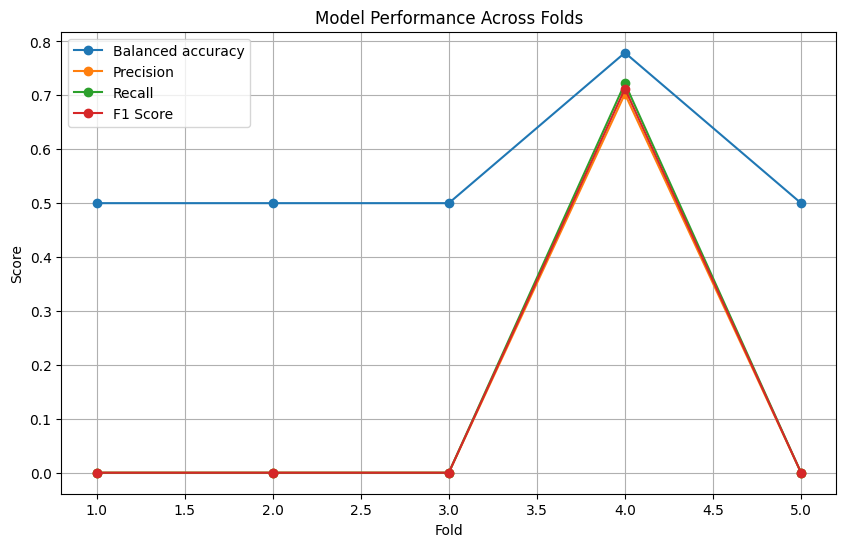

In [ ]:
print(fold_results)
# Analyze cross-validation results
accuracies = [result["eval_balanced_accuracy"] for result in fold_results]
precisions = [result["eval_precision"] for result in fold_results]
recalls = [result["eval_recall"] for result in fold_results]
f1_scores = [result["eval_f1"] for result in fold_results]

print("\nCross-validation summary:")
print(f"Balanced accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Precision: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
print(f"Recall: {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Visualize metrics across folds
plt.figure(figsize=(10, 6))
fold_nums = list(range(1, n_splits + 1))
plt.plot(fold_nums, accuracies, "o-", label="Balanced accuracy")
plt.plot(fold_nums, precisions, "o-", label="Precision")
plt.plot(fold_nums, recalls, "o-", label="Recall")
plt.plot(fold_nums, f1_scores, "o-", label="F1 Score")
plt.xlabel("Fold")
plt.ylabel("Score")
plt.title("Model Performance Across Folds")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Tokenize datasets
train_dataset = tokenize_texts(
    X_train, 
    y_train, 
    tokenizer, 
    max_length=config["data"]["max_length"]
)
test_dataset = tokenize_texts(
    X_test, 
    y_test, 
    tokenizer, 
    max_length=config["data"]["max_length"]
)

# Create final model
final_model = XLMRobertaForSequenceClassification.from_pretrained(
    model_name,
    config=xlm_roberta_config
).to(device)

# Training arguments for final model
final_training_args = TrainingArguments(
    output_dir=f"{config["training"]["output_dir"]}/xlm_roberta_final",
    learning_rate=config["training"]["learning_rate"],
    per_device_train_batch_size=config["training"]["batch_size"],
    per_device_eval_batch_size=config["training"]["eval_batch_size"],
    num_train_epochs=config["training"]["epochs"],
    weight_decay=config["training"]["weight_decay"],
    evaluation_strategy=config["training"]["evaluation_strategy"],
    save_strategy=config["training"]["save_strategy"],
    load_best_model_at_end=config["training"]["load_best_model_at_end"],
    metric_for_best_model=config["training"]["metric_for_best_model"],
    save_total_limit=config["training"]["save_total_limit"],
    fp16=torch.cuda.is_available(),
)

# Initialize trainer
final_trainer = Trainer(
    model=final_model,
    args=final_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=config["training"]["early_stopping_patience"])]
)

# Train the model
final_trainer.train()

# Check if best model was loaded
print(f"Best model loaded from checkpoint: {final_trainer.state.best_model_checkpoint}")

# Evaluate and save the model
test_results = final_trainer.evaluate()
print("\nTest set evaluation:")
print(test_results)

# Save the final model
final_trainer.save_model(final_training_args.output_dir)
tokenizer.save_pretrained(final_training_args.output_dir)# Train final model using the original train/test split

Map:   0%|          | 0/516 [00:00<?, ? examples/s]

Map:   0%|          | 0/129 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/tinnitussen/DAT550/DAT550-2025---Hyperpartisan-News-Detection-/.venv/lib/python3.12/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_2345/3320215676.py:38: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

In [ ]:
test_true_labels = test_results["true_labels"]
test_predictions = test_results["predictions"]

errors = [(i, pred, true) for i, (pred, true) in 
         enumerate(zip(test_predictions, test_true_labels)) if pred != true]

print(f"\nTotal errors: {len(errors)} out of {len(test_predictions)} samples ({len(errors)/len(test_predictions)*100:.2f}%)")

for i, (idx, pred, true) in enumerate(errors[:5]):
    actual_idx = X_test.index[idx]  # Get the original index in the dataset
    text = X_test.iloc[idx][:500] + "..."  # Show first 500 chars
    
    print(f"\nError {i+1}:")
    print(f"Predicted: {"hyperpartisan" if pred == 1 else "not hyperpartisan"}")
    print(f"Actual: {"hyperpartisan" if true == 1 else "not hyperpartisan"}")
    print(f"Text snippet: {text}")


In [ ]:
def predict_hyperpartisan(text, model=final_model, tokenizer=tokenizer):
    """Predict if a text is hyperpartisan"""
    # Tokenize
    inputs = tokenizer(
        text,
        add_special_tokens=True,
        max_length=config["data"]["max_length"],
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(outputs.logits, dim=1).item()
        confidence = probs[0][prediction].item()
    
    return {
        "prediction": "hyperpartisan" if prediction == 1 else "not hyperpartisan",
        "confidence": confidence,
        "label": prediction
    }

sample_texts = [
    X_test.iloc[0],  
    "This article proves that the President is the worst in history and a complete disaster for America.",  # Likely hyperpartisan
    "The Senate voted yesterday on the new healthcare bill, with 45 votes for and 55 against."  # Likely not hyperpartisan
]

for i, text in enumerate(sample_texts):
    result = predict_hyperpartisan(text)
    print(f"\nSample {i+1}:")
    print(f"Prediction: {result["prediction"]}")
    print(f"Confidence: {result["confidence"]:.4f}")